In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split



Matplotlib is building the font cache; this may take a moment.


In [2]:
# Load data
df = pd.read_csv('data/data.csv')

In [4]:
# plot a cofusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
df.head()

,Text,Polarity
0,আমাদের সজাগ থাকতে হবে টিকা নেওয়া নিয়ে।,1
1,ভ্যাকসিন ভালো না।,0
2,আমার পরিবারের সকলেই টিকা নিয়েছে।,1
3,টিকা লক্ষণীয় রোগ প্রতিরোধে একইভাবে উচ্চ কার্য...,1
4,অনলাইনে আবেদন করে আমি ভ্যাকসিন নিয়েছি।,1


In [6]:
# train test and validation split
train_val, test = train_test_split(df[['Text','Polarity']].to_numpy(), test_size=0.2)
train, val = train_test_split(train_val, test_size=0.2)










In [7]:
train_sentence,train_label = train[:,0], train[:,1]
train_label = train_label.astype('int')
test_sentence,test_label = test[:,0], test[:,1]
test_label = test_label.astype('int')
val_sentence,val_label = val[:,0], val[:,1]
val_label = val_label.astype('int')




In [8]:
train_sentence.shape,train_label.shape,test_sentence.shape,test_label.shape,val_sentence.shape,val_label.shape

((2436,), (2436,), (762,), (762,), (609,), (609,))

In [9]:
from keras.layers.preprocessing.text_vectorization import TextVectorization

In [10]:
max_voc_size = 10000
max_len = np.round(np.average([len(word.split(' ')) for word in test_sentence]))



tex_vec = TextVectorization(
    max_tokens = max_voc_size,
    output_mode='int',
    output_sequence_length=int(max_len)
)

In [11]:
tex_vec.adapt(train_sentence)

tex_vec([train_sentence[0]])

<tf.Tensor: shape=(1, 11), dtype=int64, numpy=
array([[  83, 4108, 1673,   38, 1246,    0,    0,    0,    0,    0,    0]],
      dtype=int64)>

In [12]:
# build a LSTM
from keras.layers import Embedding

In [13]:
embedding= Embedding(input_dim=max_voc_size,output_dim=128,input_length=max_len)

In [14]:
# build a LSTM model

input = layers.Input(shape=(1,), dtype='string')
x = tex_vec(input)
x= embedding(x)
x = layers.LSTM(64)(x)
output = layers.Dense(1,activation='sigmoid')(x)
model_lstm = keras.Model(input,output,)

In [15]:
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [16]:
model_lstm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 11)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 11, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
___________________________________________________

In [17]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

earlystoper = EarlyStopping(patience=3, restore_best_weights=True)

In [18]:
model_lstm_history = model_lstm.fit(
    train_sentence,
    train_label,
    epochs=10,
    validation_data = (val_sentence,val_label),
    callbacks=[earlystoper]
)


Epoch 1/10
77/77 [==============================] - 6s 33ms/step - loss: 0.6139 - accuracy: 0.6490 - val_loss: 0.5124 - val_accuracy: 0.7471
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 0.3472 - accuracy: 0.8518 - val_loss: 0.4939 - val_accuracy: 0.7438
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 0.1991 - accuracy: 0.9175 - val_loss: 0.5639 - val_accuracy: 0.7488
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 0.1258 - accuracy: 0.9511 - val_loss: 0.7134 - val_accuracy: 0.7455
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 0.0911 - accuracy: 0.9631 - val_loss: 0.9797 - val_accuracy: 0.7291


In [19]:
model_lstm_pred_prob= model_lstm.predict(test_sentence)

pred_lstm = tf.squeeze(tf.round(model_lstm_pred_prob))

24/24 [==============================] - 1s 7ms/step


In [20]:
from sklearn.metrics import accuracy_score

In [21]:
accuracy_score(test_label,pred_lstm)

0.7532808398950132

In [22]:
model_lstm.save('./model_lstm/')

INFO:tensorflow:Assets written to: ./model_lstm/assets


INFO:tensorflow:Assets written to: ./model_lstm/assets


In [23]:
from keras.utils import plot_model

In [24]:
plot_model(model_lstm, to_file='model_lstm.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [25]:
# Build with GRU

input = layers.Input(shape=(1,), dtype='string')
x = tex_vec(input)
x= embedding(x)
x = layers.GRU(64)(x)
output = layers.Dense(1,activation='sigmoid')(x)
model_gru = keras.Model(input,output,)
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_gru.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 11)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 11, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________

In [26]:
# train the model
model_gru_history = model_gru.fit(
    train_sentence,
    train_label,
    epochs=10,
    validation_data = (val_sentence,val_label),
    callbacks=[earlystoper]
)


Epoch 1/10
77/77 [==============================] - 7s 34ms/step - loss: 0.3976 - accuracy: 0.8522 - val_loss: 0.5617 - val_accuracy: 0.7553
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 0.1818 - accuracy: 0.9261 - val_loss: 0.6682 - val_accuracy: 0.7422
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 0.1139 - accuracy: 0.9561 - val_loss: 0.6262 - val_accuracy: 0.7685
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 0.0889 - accuracy: 0.9647 - val_loss: 0.7653 - val_accuracy: 0.7537


In [27]:
# predict
model_gru_pred_prob= model_gru.predict(test_sentence)

pred_gru = tf.squeeze(tf.round(model_gru_pred_prob))

# accuracy
accuracy_score(test_label,pred_gru)


24/24 [==============================] - 1s 5ms/step


0.7480314960629921

In [28]:
model_gru.save('./model_gru/')

INFO:tensorflow:Assets written to: ./model_gru/assets


INFO:tensorflow:Assets written to: ./model_gru/assets


In [28]:
# calculate and plot the confusion matrix for LSTM, GRU 
from sklearn.metrics import confusion_matrix
import itertools

cm_lstm = confusion_matrix(test_label,pred_lstm)
cm_gru = confusion_matrix(test_label,pred_gru)


In [30]:
cm_gru,cm_lstm

(array([[281,  69],
        [104, 308]]),
 array([[274,  76],
        [ 84, 328]]))

Confusion matrix, without normalization
[[274  76]
 [ 84 328]]
Confusion matrix, without normalization
[[281  69]
 [104 308]]


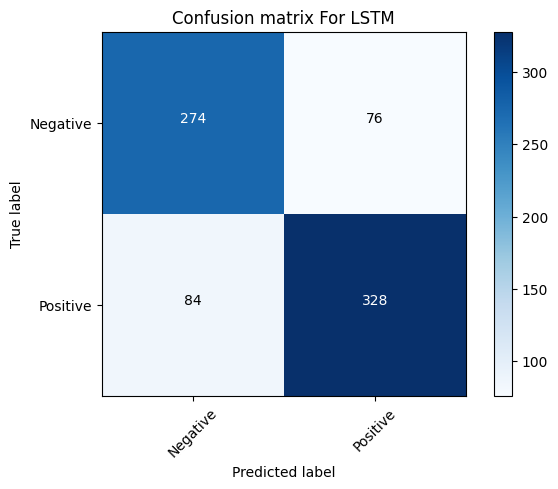

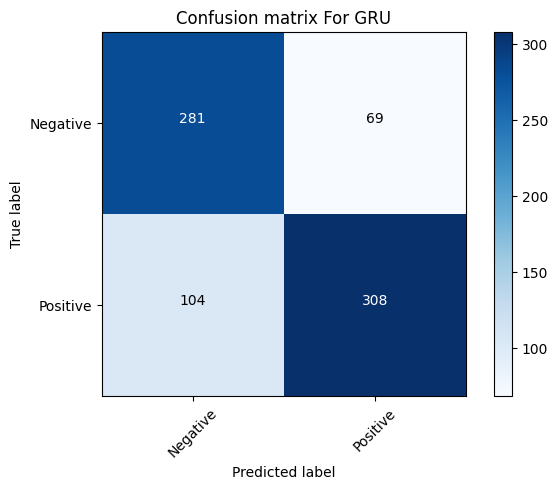

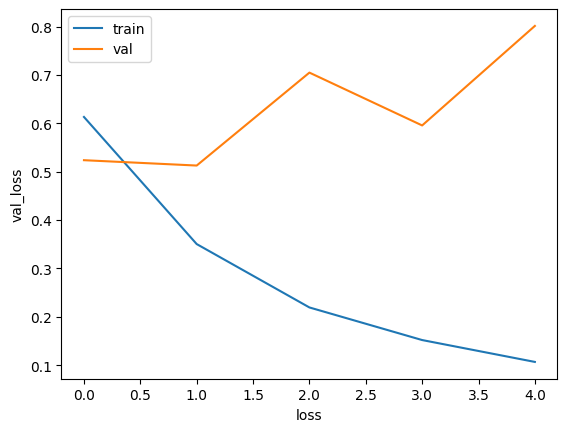

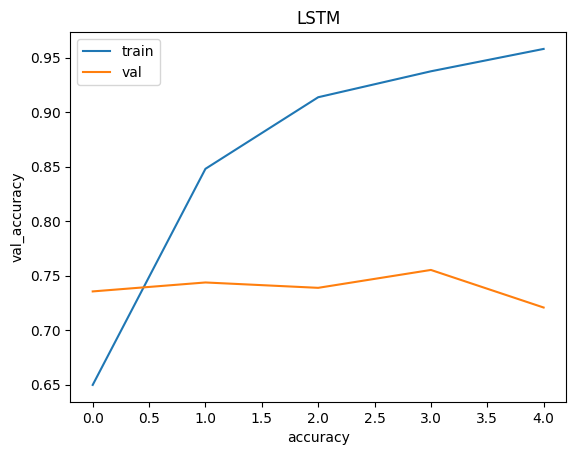

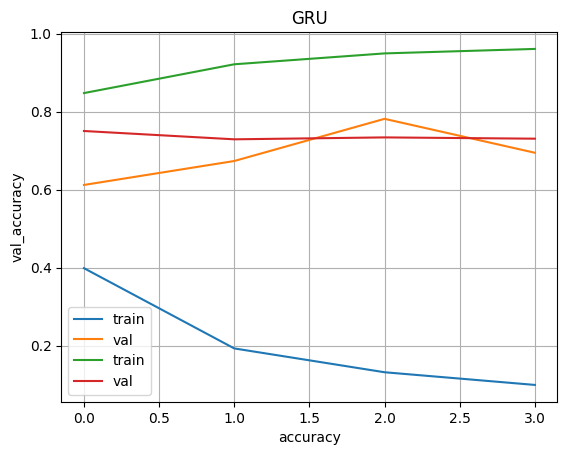

In [38]:
# plot the confusion matrix
class_names = ['Negative','Positive']
plt.figure()
plot_confusion_matrix(cm_lstm, classes=class_names,
                        title='Confusion matrix For LSTM')
plt.figure()
plot_confusion_matrix(cm_gru, classes=class_names,

                        title='Confusion matrix For GRU')
plt.show()

# plot the loss and accuracy for LSTM, GRU
plt.plot(model_lstm_history.history['loss'], label='train')
plt.xlabel('loss')
plt.ylabel('val_loss')
plt.plot(model_lstm_history.history['val_loss'], label='val')
plt.legend()
plt.show()

plt.plot(model_lstm_history.history['accuracy'], label='train')
plt.plot(model_lstm_history.history['val_accuracy'], label='val')
plt.xlabel('accuracy')
plt.ylabel('val_accuracy')
plt.title('LSTM')
plt.legend()
plt.show()

plt.plot(model_gru_history.history['loss'], label='train')
plt.xlabel('loss')
plt.ylabel('val_loss')
plt.title('GRU')
plt.plot(model_gru_history.history['val_loss'], label='val')
plt.legend()

plt.plot(model_gru_history.history['accuracy'], label='train')
plt.xlabel('accuracy')
plt.ylabel('val_accuracy')
plt.grid()
plt.title('GRU')

plt.plot(model_gru_history.history['val_accuracy'], label='val')
plt.legend()



In [32]:
### load nn model

nn_model = keras.models.load_model('./nn_model/')

In [33]:
### calculate and plot the confusion matrix for nn model

nn_model_pred_prob = nn_model.predict(test_sentence)

pred_nn = tf.squeeze(tf.round(nn_model_pred_prob))

cm_nn = confusion_matrix(test_label,pred_nn)

cm_nn   

24/24 [==============================] - 0s 5ms/step


array([[290,  60],
       [ 32, 380]])

Confusion matrix, without normalization
[[290  60]
 [ 32 380]]


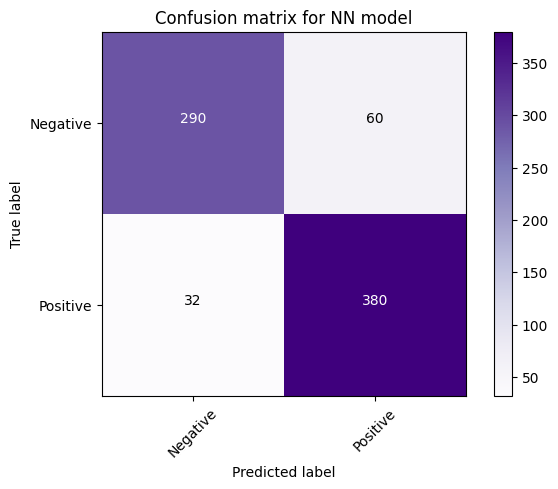

In [35]:
# plot the confusion matrix
class_names = ['Negative','Positive']
plt.figure()
plot_confusion_matrix(cm_nn, classes=class_names,
                        title='Confusion matrix for NN model',cmap=plt.cm.Purples)
plt.show()

